Flesch–Kincaid readability tests

The Gunning Fog index: How low should you go?

https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_Reading_Ease


https://medium.com/@annwylie/the-gunning-fog-index-how-low-should-you-go-bd9d9df52279

In [ ]:
# language score calculation notebook for North America

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from textblob import TextBlob
import string
from scipy.stats import zscore # note, this uses regular, not sample standard deviation
import re
#pip install nltk
#pip install textstat

[nltk_data] Downloading package punkt to /home/wot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wot/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Flesch-Kincaid and Gunning-Fog

import textstat

# Example text for readability analysis
text = "This is an example sentence. It has multiple clauses and uses some technical terms. The complexity of this text will be evaluated."

# Calculate Flesch-Kincaid Grade Level
flesch_grade = textstat.flesch_kincaid_grade(text)
print("Flesch-Kincaid Grade Level:", flesch_grade)

# Calculate Gunning Fog Index
gunning_fog = textstat.gunning_fog(text)
print("Gunning Fog Index:", gunning_fog)


Flesch-Kincaid Grade Level: 7.3
Gunning Fog Index: 12.01


In [3]:
def flesch_grade(text):
    # did not remove punctuation for these--flesch and gunning seem to require punctuation for sentence complexity
    if pd.isna(text):
        return np.nan
    else:
        return textstat.flesch_kincaid_grade(text)

def gunning_grade(text):
    # did not remove punctuation for these--flesch and gunning seem to require punctuation for sentence complexity
    if pd.isna(text):
        return np.nan
    else:
        return textstat.gunning_fog(text)

def calculate_cohesion(tweet):
    
    if pd.isna(tweet):
        return np.nan
    
    # Tokenize the tweet into individual words
    tokens = word_tokenize(tweet.lower())

    # Remove punctuation marks for cohesion score--do not want to count punctuation as tokens
    tokens = [token for token in tokens if token not in string.punctuation]
    
    if len(tokens) == 0:
        print("problem with tweet having no tokens: %s" % tweet)
        raise ValueError

    # Calculate the frequency distribution of tokens
    freq_dist = FreqDist(tokens)

    # Calculate the cohesion score based on the number of unique words
    cohesion_score = len(freq_dist) / len(tokens)

    return cohesion_score

def calculate_coherence(tweet):
    
    if pd.isna(tweet):
        return np.nan
    
    # fetch keywords
    keywords = fetch_keywords(tweet)
    keywords = [x.lower() for x in keywords]
    
    # Tokenize the tweet into individual words
    tokens = word_tokenize(tweet.lower())

    # Remove punctuation marks
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # some tweets can just be punctuation (for example)
    #assert len(tokens) > 0, f"problem with non-empty tweet having no tokens: {tweet}"
    if len(tokens) == 0:
        print("problem with tweet having no tokens: %s" % tweet)
        raise ValueError

    # Calculate the frequency distribution of tokens
    freq_dist = FreqDist(tokens)

    # Calculate the coherence score based on the presence of keywords
    coherence_score = sum(freq_dist[keyword] for keyword in keywords) / len(tokens)

    return coherence_score

# helper function, for coherence score
def fetch_keywords(tweet):
    # Perform part-of-speech tagging on the tweet
    blob = TextBlob(tweet)
    pos_tags = blob.tags

    # Extract nouns and adjectives as keywords
    keywords = [word for word, pos in pos_tags if pos.startswith("N") or pos.startswith("J")]

    return keywords



In [15]:
# some of the North America text columns still had mentions (@...); these may interfere with syllable counts for
# Flesch and Gunning (?)
def remove_mentions(tweet):
    if isinstance(tweet, str):
        tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        return tweet
    else:
        return np.nan

In [30]:
df = pd.read_csv('North_America_sentiment_analysis.csv') # use the cleaned text (with punctuation) from the sentiment 
# analysis calculation

In [31]:
df.columns

Index(['tweet_id', 'text', 'text_parse', 'txt htg', 'txt mnt', 'reply1',
       'reply1_parse', 'r1 htg', 'r1 mnt', 'reply2', 'reply2_parse', 'r2 htg',
       'r2 mnt', 'likes count', 'quote_tweet count', 'retweet count',
       'timestamp', 'followers', 'username', 'display name', 'gender',
       'country', 'text_cleaned', 'text_sentiment', 'reply1_cleaned',
       'reply1_sentiment', 'reply2_cleaned', 'reply2_sentiment'],
      dtype='object')

In [32]:
# we're supposed to remove mentions (and hashtags) before doing language score (?)
df['text_cleaned_2'] = df['text_cleaned'].apply(remove_mentions)

In [4]:
# define a function to compute z-scores on a Pandas column; could also use scipy.stats 
# zscore(), which though does not work with np.nan values (?)
def zscore_custom(in_series):
    # input a Pandas series (for example a dataframe column), or maybe a numpy array;
    # this uses Pandas' mean() and std() handling of np.nan values--which ignores them
    # ddof=0 is to match scipy.stats zscore output--debatable if necessary
    return (in_series-in_series.mean())/in_series.std(ddof=0)

In [33]:
# language score functions are run on tweets preprocessed for sentiment
col_nam = 'text_cleaned_2' # only calculate language scores for main tweets--not for replies
df['Flesch_Kincaid'] = df[col_nam].apply(flesch_grade)
df['Gunning_Fog'] = df[col_nam].apply(gunning_grade)
df['coherence'] = df[col_nam].apply(calculate_coherence)
df['cohesion'] = df[col_nam].apply(calculate_cohesion)

In [60]:
# see means and standard deviations, just for reference
mu = df['Flesch_Kincaid'].mean()
sdv = df['Flesch_Kincaid'].std(ddof=0)
print("%s; %s" % (mu,sdv))

mu = df['Gunning_Fog'].mean()
sdv = df['Gunning_Fog'].std(ddof=0)
print("%s; %s" % (mu,sdv))

mu = df['coherence'].mean()
sdv = df['coherence'].std(ddof=0)
print("%s; %s" % (mu,sdv))

mu = df['cohesion'].mean()
sdv = df['cohesion'].std(ddof=0)
print("%s; %s" % (mu,sdv))


6.515349112426036; 4.2059862366974246
8.432366863905326; 4.680993474131172
0.48049820258998843; 0.2235100629762865
0.9180046435899515; 0.08405657293262761


In [39]:
# compute z-scores, using custom function
df['F_z'] = zscore_custom(df['Flesch_Kincaid'])
df['G_z'] = zscore_custom(df['Gunning_Fog'])
df['coher_z'] = zscore_custom(df['coherence'])
df['cohes_z'] = zscore_custom(df['cohesion'])

In [40]:
df['language_score'] = 0.4*df['coher_z']-0.3*df['F_z']+0.2*df['cohes_z']-0.1*df['G_z']

In [41]:
df.columns

Index(['tweet_id', 'text', 'text_parse', 'txt htg', 'txt mnt', 'reply1',
       'reply1_parse', 'r1 htg', 'r1 mnt', 'reply2', 'reply2_parse', 'r2 htg',
       'r2 mnt', 'likes count', 'quote_tweet count', 'retweet count',
       'timestamp', 'followers', 'username', 'display name', 'gender',
       'country', 'text_cleaned', 'text_sentiment', 'reply1_cleaned',
       'reply1_sentiment', 'reply2_cleaned', 'reply2_sentiment',
       'text_cleaned_2', 'Flesch_Kincaid', 'Gunning_Fog', 'coherence',
       'cohesion', 'F_z', 'G_z', 'coher_z', 'cohes_z', 'language_score'],
      dtype='object')

In [42]:
# only save columns relevant to language score
df = df[['tweet_id', 'username', 'text', 'text_parse', 'text_cleaned', 'Flesch_Kincaid', 
         'Gunning_Fog', 'coherence',
       'cohesion', 'F_z', 'G_z', 'coher_z', 'cohes_z', 'text_cleaned_2', 'language_score']]

In [43]:
df.to_csv("language_scores_North_America.csv", index=False)

In [44]:
# most of the z-scores are ~reasonable; there are however large outliers
print(max(df['F_z']), min(df['F_z']))
print(max(df['G_z']), min(df['G_z']))
print(max(df['coher_z']), min(df['coher_z']))
print(max(df['cohes_z']), min(df['cohes_z']))
# percentiles--middle 90% of scores, and median
print(df['F_z'].quantile([0.05,0.5,0.95])) 
print(df['G_z'].quantile([0.05,0.5,0.95]))
print(df['coher_z'].quantile([0.05,0.5,0.95]))
print(df['cohes_z'].quantile([0.05,0.5,0.95]))

11.670188185426788 -2.3812130018499946
7.085596961284131 -1.7159534419979499
40.35389582601005 -2.1497833081500555
0.9754782231696362 -9.017791436697063
0.05   -1.430188
0.50   -0.098752
0.95    1.731972
Name: F_z, dtype: float64
0.05   -1.374146
0.50   -0.068867
0.95    1.796122
Name: G_z, dtype: float64
0.05   -1.191054
0.50   -0.129235
0.95    1.578610
Name: coher_z, dtype: float64
0.05   -1.823757
0.50    0.164336
0.95    0.975478
Name: cohes_z, dtype: float64


In [6]:
import matplotlib.pyplot as plt

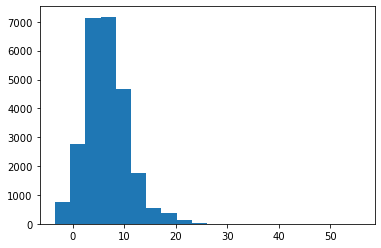

In [34]:
plt.hist(df['Flesch_Kincaid'],bins=20)
plt.show()

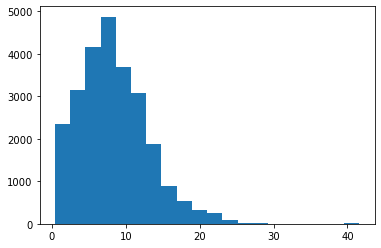

In [35]:
plt.hist(df['Gunning_Fog'],bins=20)
plt.show()

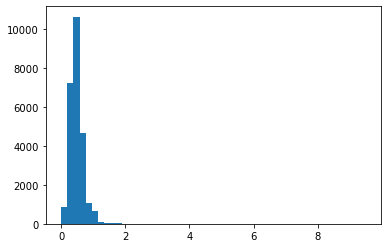

In [36]:
plt.hist(df['coherence'],bins=50)
plt.show()

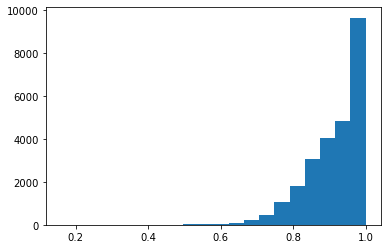

In [37]:
# this is the "worst" distribution, from a normal / bell curve standpoint--z-scores may have
# strange outliers for this column
plt.hist(df['cohesion'],bins=20)
plt.show()

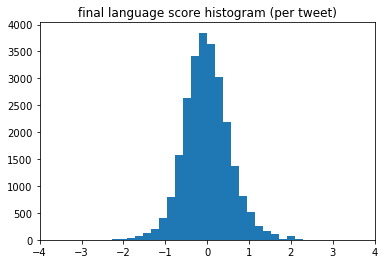

0.05   -0.844226
0.50   -0.023614
0.95    0.926868
Name: language_score, dtype: float64


In [57]:
# distribution of overall language score values
plt.hist(df['language_score'],bins=100)
plt.xlim([-4,4])
plt.title('final language score histogram (per tweet)')
plt.show()
print(df['language_score'].quantile([0.05,0.5,0.95]))